In [1]:
import pandas as pd
#from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
#Notes
#successfully labeled which messages contain laughs
#now need to create lists/dataframes for each person to track laughs given/laughs received
#need some kind of visualization of time series

In [2]:
chat = pd.read_csv('Fantasy Babymakers 9.2014-10.2019.csv')
chat.head(15)

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime
0,NaN,9/15/2014,NaN,NaN,Patrick Deane,Yo negros,Text,NaN,NaN,NaN,NaN
1,NaN,9/15/2014,NaN,NaN,Patrick Deane,Can someone invite Kris and KJ and Luke if the...,Text,NaN,NaN,NaN,NaN
2,NaN,9/15/2014,NaN,NaN,Ben Deane,Yooooo,Text,NaN,NaN,NaN,NaN
3,NaN,9/15/2014,NaN,NaN,Patrick Deane,"Yo nobody blow me up about tonight's game, I'm...",Text,NaN,NaN,NaN,NaN
4,NaN,9/15/2014,NaN,NaN,Patrick Deane,Tomorrow,Text,NaN,NaN,NaN,NaN
5,NaN,9/15/2014,NaN,NaN,Duncan Bell,Hopefully Luck scored -2 points. That would b...,Text,NaN,NaN,NaN,NaN
6,NaN,9/15/2014,NaN,NaN,Patrick Deane,GL with that Dunc... Although if I woulda had ...,Text,NaN,NaN,NaN,NaN
7,NaN,9/15/2014,NaN,NaN,Duncan Bell,Haha true. Was gonna be a close match until f...,Text,NaN,NaN,NaN,NaN
8,NaN,9/15/2014,NaN,NaN,Scott Gunter,No homo...how good is orange is the new black?,Text,NaN,NaN,NaN,NaN
9,NaN,9/15/2014,NaN,NaN,Bryan Lee,Real good,Text,NaN,NaN,NaN,NaN


In [145]:
laughs

,funny,value
0,#lol17,1
1,#lols,1
2,"\""lol\""",1
3,‘hahahaha’,3
4,ahhaahhahah,3
5,ahhhahhah,3
6,baahahahhahahahahah,3
7,bagahahsha,3
8,bahaaa,2
9,bahaahahhahahhahhha,3


In [26]:
chat = pd.read_csv('Fantasy Babymakers 9.2014-10.2019.csv')
laughs = pd.read_csv('funny_words_utf.csv')

chat.dropna(axis=0,subset=['MessageBody','UserName'],inplace=True)
chat.reset_index(inplace=True)

#dictionary for looking up laughter weight value
laughs_dict = {}
for laugh, value in zip(laughs['funny'],laughs['value']):
    laughs_dict.update( {laugh : value} )

#marking messages that contain laughter
laugh = []
for message in chat.MessageBody:
    if isinstance(message,float) is False:
        message_laughs = 0
        for word in message.lower().split():
            if (word in list(laughs.funny)) | (word == '😂') | (word == '🤣') | (word == '😆'):
                message_laughs = message_laughs + 1
        if message_laughs > 0:
            laugh.append(1)
        else:
            laugh.append(0)
    else:
        laugh.append(0)
chat['laugh'] = laugh

#weighting laughs according to the severity
max_weights=[]
for message,laugh in zip(chat.MessageBody,chat.laugh):
    if laugh == 1:
        laugh_weights = []
        for word in message.lower().split():
            if word in list(laughs.funny):
                laugh_weights.append(laughs_dict[word])
        if len(laugh_weights) == 0:
            laugh_weights.append(1)
        laugh_weights.sort(reverse=True)
        max_weights.append(laugh_weights[0])
    else:
        max_weights.append(0)
chat['laugh_weight'] = max_weights

#chat[chat.laugh == 1][['MessageBody','laugh_weight']]

#splitting date into month, day, year
months = []
days = []
years = []
for date in chat.Date2:
    try:
        d = date.split('/')
        months.append(d[0])
        days.append(d[1])
        years.append(d[2])
    except:
        months.append('')
        days.append('')
        years.append('')
chat['month'] = months
chat['day'] = days
chat['year'] = years
chat['year_month'] = chat.year + chat.month

#now creating a dataframe containing jokers, their messages, laughers, their messages
jokes = []
for row in chat[chat.laugh == 1].index:
    c=0
    laugher = chat.iloc[row].UserName
    date = chat.iloc[row].Date2
    ym = chat.iloc[row].year_month
    if isinstance(chat.iloc[row].QuotedMessage,float) is False: #handle if laughter is directed at quoted message
        joker = chat.iloc[chat[(chat.Date2 == chat.iloc[row].QuotedMessageDate) & (chat.Time == chat.iloc[row].QuotedMessageTime)].index[0]].UserName
        jokes.append((date,ym,joker,chat.iloc[chat[(chat.Date2 == chat.iloc[row].QuotedMessageDate) & (chat.Time == chat.iloc[row].QuotedMessageTime)].index[0]].MessageBody,laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
        c=1
    elif row > 9: #excluding first 10 rows
        r=0
        for prev_row in range(row-1,row-11,-1): #searching previous 10 chats for joker
            r=r+1
            if c == 0:
                if (chat.iloc[prev_row].laugh == 0) & (chat.iloc[prev_row].UserName != laugher):
                    joker = chat.iloc[prev_row].UserName
                    jokes.append((date,ym,joker,chat.iloc[prev_row].MessageBody,laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
                    c=1
            elif (r == 10) & (c == 0): #if no jokers identified even after 10 previous rows, we append laugh only
                jokes.append((date,ym,'','',laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
    #else: #control for first 10 rows
    #    jokes.append((date,'','',laugher,chat.iloc[row].MessageBody,chat.iloc[row].laugh_weight))
        
jokes_df = pd.DataFrame(jokes,columns=['date','year_month','joker','joke_message','laugher','laugh_message','laugh_weight'])

#now creating summary figures to assess jokers
joker_counts = pd.DataFrame(jokes_df.joker.value_counts())
laugher_counts = pd.DataFrame(jokes_df.laugher.value_counts())
full_chat_counts = pd.DataFrame(chat.UserName.value_counts())
full_chat_counts.rename(columns={"UserName": "full_chat_count"},inplace=True)
aggregations = {
    'laugh_weight': 'sum'
}

joker_weights = jokes_df.groupby(by=['joker']).agg(aggregations)

Summary = pd.concat([joker_counts,laugher_counts,full_chat_counts,joker_weights],axis=1)
Summary.reset_index(inplace=True)
Summary.rename(columns={'joker':'joke_count','index':'joker','laugher':'laugh_count'},inplace=True)
Summary['joke_proportion'] = Summary.joke_count / (Summary.full_chat_count - Summary.laugh_count)
#Summary['weighted_laugh_proportion'] = Summary.laugh_weight / (Summary.full_chat_count - Summary.laugher)

#we will use this to assess joke distribution among chatters, could also be used as a composite metric as well
joke_count_z_scores = []
for joker,i in zip(Summary.joker, list(range(Summary.shape[0]))):
    joke_count_z_scores.append((Summary[Summary.joker == joker].joke_count[i] - Summary.joke_count.mean()) / float(Summary.joke_count.std()))
Summary['joke_count_z_score'] = joke_count_z_scores

#building a feature which describes "how spread out the laugher is" among chatters
laugher_proportions = []
for joker in jokes_df.joker.drop_duplicates():
    for laugher in jokes_df.laugher.drop_duplicates():
        if laugher != joker:
            laugher_proportions.append((joker,laugher,jokes_df[(jokes_df.joker == joker) & (jokes_df.laugher == laugher)].shape[0]\
                                           / jokes_df[jokes_df.laugher == laugher].shape[0]))

laugher_proportions_df = pd.DataFrame(data=laugher_proportions,columns=['joker','laugher','laugher_proportion'])
laugher_proportions_df.sort_values(by=['joker','laugher_proportion'], ascending=False)

from statistics import mean

laugh_distribution_scores = []
for joker in Summary.joker:
    laugher_distribution_z_scores =[]
    for laugher in laugher_proportions_df.laugher.drop_duplicates():
        if joker != laugher:
            #this is a score to indicate a laugher's laughs for given joker relative to the number of laughs for given laugher
            #point is to get at whether a joker is getting laughs from everyone or just a small number of people
            laugher_distribution_z_scores.append((list(laugher_proportions_df[(laugher_proportions_df.joker == joker) & (laugher_proportions_df.laugher == laugher)].laugher_proportion)[0]\
                                                - laugher_proportions_df[laugher_proportions_df.laugher == laugher].laugher_proportion.mean())\
                                                / float(laugher_proportions_df[laugher_proportions_df.laugher == laugher].laugher_proportion.std()))
    comparison_scores = []
    for value in laugher_distribution_z_scores:
        #we compare the joke count z score to these laugher distribution scores and then take mean
        comparison_scores.append((value + 3) - (list(Summary[Summary.joker == joker].joke_count_z_score)[0] + 3))
    laugh_distribution_scores.append(mean(comparison_scores)+1)

Summary['laugh_distribution_score'] = laugh_distribution_scores

#creating a metric to credit jokers who make multiple people laugh
big_joke_counts = []
for joker in Summary.joker:
    joker_df = jokes_df[jokes_df.joker == joker]
    joker_df_counts = pd.DataFrame(joker_df.joke_message.value_counts())
    big_joke_counts.append(joker_df_counts[joker_df_counts.joke_message >= 2].shape[0]) #count number of jokes having at least 2 laughs
Summary['big_joke_count'] = big_joke_counts

#creating the z scores that we'll use for composite score

weighted_laughs_z_scores = []
for value in Summary.laugh_weight:
    weighted_laughs_z_scores.append(((value - Summary.laugh_weight.mean()) / Summary.laugh_weight.std())+3)
    
Summary['weighted_laughs_z_score'] = weighted_laughs_z_scores

joke_proportion_z_scores = []
for value in Summary.joke_proportion:
    joke_proportion_z_scores.append(((value - Summary.joke_proportion.mean()) / Summary.joke_proportion.std())+3)
    
Summary['joke_proportion_z_score'] = joke_proportion_z_scores

laugh_distribution_z_scores = []
for value in Summary.laugh_distribution_score:
    laugh_distribution_z_scores.append(((value - Summary.laugh_distribution_score.mean()) / Summary.laugh_distribution_score.std())+3)
    
Summary['laugh_distribution_z_score'] = laugh_distribution_z_scores

big_joke_z_scores = []
for value in Summary.big_joke_count:
    big_joke_z_scores.append(((value - Summary.big_joke_count.mean()) / Summary.big_joke_count.std())+3)
    
Summary['big_joke_z_score'] = big_joke_z_scores

#2x weighted laughs score, 1x for laugh proportion and joke distribution
Summary['composite_humor_score'] = (Summary['weighted_laughs_z_score'] + Summary['big_joke_z_score'] + Summary['joke_proportion_z_score'] + Summary['laugh_distribution_z_score']) / 4
Summary.sort_values(by=['composite_humor_score'],ascending=False,inplace=True)
Summary

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,joker,joke_count,laugh_count,full_chat_count,laugh_weight,joke_proportion,joke_count_z_score,laugh_distribution_score,big_joke_count,weighted_laughs_z_score,joke_proportion_z_score,laugh_distribution_z_score,big_joke_z_score,composite_humor_score
9,Scott Gunter,536,263,5954,960,0.094184,1.260559,0.892881,55,4.200451,3.270947,2.488813,4.681066,3.660319
5,Krista Gunter,597,292,5864,1110,0.107143,1.598406,0.544598,49,4.657011,3.870172,0.826763,4.308874,3.415705
8,Patrick Deane,475,428,5854,869,0.087541,0.922711,0.864717,43,3.923470,2.963807,2.354411,3.936682,3.294593
7,Mark Casstevens,358,696,5449,624,0.075321,0.274709,1.253587,31,3.177754,2.398728,4.210149,3.192299,3.244733
6,Luke Wray,140,128,1321,264,0.117351,-0.932681,1.079570,21,2.082008,4.342204,3.379719,2.571980,3.093978
4,Kevin Jellerson,177,175,1844,344,0.106052,-0.727757,1.129304,9,2.325508,3.819709,3.617055,1.827596,2.897467
3,Duncan Bell,161,174,2025,289,0.086980,-0.816373,1.126690,20,2.158102,2.937845,3.604580,2.509948,2.802619
0,Ben Deane,251,204,3123,490,0.085988,-0.317909,0.895274,22,2.769893,2.891991,2.500234,2.634011,2.699032
1,Bryan Lee,69,124,945,117,0.084044,-1.325913,1.208900,9,1.634579,2.802078,3.996895,1.827596,2.565287
2,David Casstevens,320,600,8882,589,0.038638,0.064246,1.004480,20,3.071223,0.702520,3.021381,2.509948,2.326268


In [171]:
#I think there's a problem with how I am calculating the joke distribution.  double counting if multiple laughs
#should take proportion of jokes to total chats?  should I be considering laugh weight?
Summary.laugh_count.sum()

3084

In [8]:
laugher_proportions_df.sort_values(by='laugher_proportion',ascending=False).head(10)

,joker,laugher,laugher_proportion
44,Krista Gunter,Kevin Jellerson,0.308571
5,Scott Gunter,Bryan Lee,0.266129
4,Scott Gunter,Duncan Bell,0.264368
20,Patrick Deane,Scott Gunter,0.262357
6,Scott Gunter,Luke Wray,0.257812
36,Krista Gunter,Mark Casstevens,0.254310
1,Scott Gunter,Patrick Deane,0.242991
19,Patrick Deane,David Casstevens,0.231667
40,Krista Gunter,Ben Deane,0.210784
38,Krista Gunter,David Casstevens,0.210000


In [20]:
months = []
days = []
years = []
for date in jokes_df.date:
    try:
        d = date.split('/')
        months.append(d[0])
        days.append(d[1])
        years.append(d[2])
    except:
        months.append('')
        days.append('')
        years.append('')
jokes_df['month'] = months
jokes_df['day'] = days
jokes_df['year'] = years
jokes_df['month_year'] = jokes_df.year + jokes_df.month
jokes_df.head()



,date,joker,joke_message,laugher,laugh_message,laugh_weight,month,day,year,month_year
0,9/15/2014,Scott Gunter,...and the boobs,Mark Casstevens,Hahahahha,3,9,15,2014,20149
1,9/16/2014,Duncan Bell,Orange is the new black is the shit,Patrick Deane,Hahahaha,3,9,16,2014,20149
2,9/18/2014,Patrick Deane,I got T New on waivers as well,David Casstevens,Hahaha,2,9,18,2014,20149
3,9/18/2014,Duncan Bell,David thing is I don't want Fred Jackson so th...,David Casstevens,Hahaha you will come crawling after this week....,2,9,18,2014,20149
4,9/18/2014,Ben Deane,Gotta love when the nfl says no chance of appeal!,David Casstevens,Hahahaha you guys are too funny. Suplee too much,3,9,18,2014,20149


In [31]:
date_aggregations = {
    'year_month': 'count'
}

chat_dates = chat.groupby(by=['year_month']).agg(date_aggregations)
chat_dates

,year_month
year_month,
201410,207
20149,383
201512,293
20161,813
201610,2080
20162,133
20163,167
20164,134
20165,32


In [11]:
chat.iloc[29067:29077].MessageBody

29067    Yes, but need to get out the electron microsco...
29068    Except Pat used one last year and had a terrib...
29069                                                  Lol
29070                                                  Lol
29071    I really don’t see why we would ban it, it’s t...
29072    Shit. If you think you’ve cracked it good for you
29073     So much goes into the season more than the draft
29074    I would vote to use it. Anyone who doesn’t use...
29075    I dont like this. It gets the feeling like we ...
29076    I like keeping it simple and everyone having e...
Name: MessageBody, dtype: object

In [13]:
chat.iloc[29068].MessageBody

'Except Pat used one last year and had a terrible season'

<BarContainer object of 10 artists>

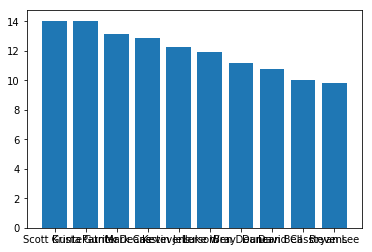

In [133]:
plt.bar(Summary.joker,Summary.composite_humor_score)

In [163]:
joker_df = jokes_df[jokes_df.joker == 'Duncan Bell']
joker_df_counts = pd.DataFrame(joker_df.joke_message.value_counts())
joker_df_counts[joker_df_counts.joke_message >= 5].shape[0]

0

In [148]:
for joker in jokes_df.joker.drop_duplicates():
    print(joker)
    print(jokes_df[jokes_df.joker == joker].laugher.value_counts())

Scott Gunter
Mark Casstevens     121
Patrick Deane       104
David Casstevens     94
Duncan Bell          46
Ben Deane            42
Bryan Lee            33
Luke Wray            33
Kevin Jellerson      32
Krista Gunter        29
Scott Gunter          2
Name: laugher, dtype: int64
Duncan Bell
David Casstevens    33
Patrick Deane       30
Mark Casstevens     28
Krista Gunter       22
Scott Gunter        20
Bryan Lee            9
Kevin Jellerson      9
Luke Wray            8
Ben Deane            2
Name: laugher, dtype: int64
Patrick Deane
David Casstevens    139
Mark Casstevens     107
Scott Gunter         69
Krista Gunter        44
Ben Deane            33
Duncan Bell          27
Kevin Jellerson      21
Bryan Lee            18
Luke Wray            17
Name: laugher, dtype: int64
Ben Deane
David Casstevens    66
Mark Casstevens     52
Patrick Deane       43
Scott Gunter        35
Krista Gunter       27
Duncan Bell          9
Kevin Jellerson      8
Bryan Lee            8
Luke Wray           

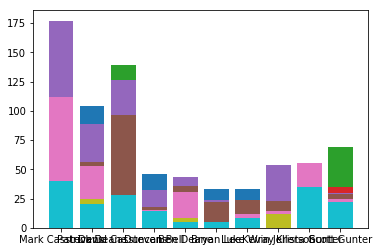

In [105]:
for joker in jokes_df.joker.drop_duplicates():
    jokers = jokes_df[jokes_df.joker == joker].laugher.value_counts().index
    values = jokes_df[jokes_df.joker == joker].laugher.value_counts().values
    plt.bar(jokers,values)

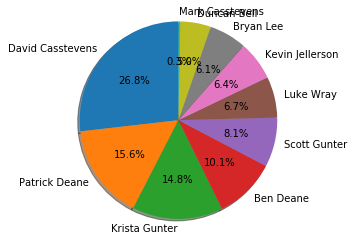

In [109]:
joker = 'Mark Casstevens'
jokers = jokes_df[jokes_df.joker == joker].laugher.value_counts().index
values = jokes_df[jokes_df.joker == joker].laugher.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=jokers, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

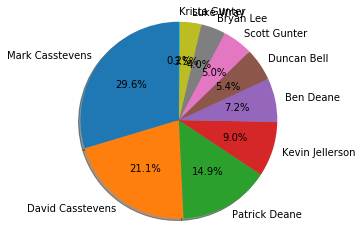

In [110]:
joker = 'Krista Gunter'
jokers = jokes_df[jokes_df.joker == joker].laugher.value_counts().index
values = jokes_df[jokes_df.joker == joker].laugher.value_counts().values
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=jokers, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [15]:
laugher_proportions_df = pd.DataFrame(data=laugher_proportions,columns=['joker','laugher','laugher_proportion'])
laugher_proportions_df.sort_values(by=['joker','laugher_proportion'], ascending=False)

,joker,laugher,laugher_proportion
5,Scott Gunter,Bryan Lee,0.266129
4,Scott Gunter,Duncan Bell,0.264368
6,Scott Gunter,Luke Wray,0.257812
1,Scott Gunter,Patrick Deane,0.242991
3,Scott Gunter,Ben Deane,0.205882
8,Scott Gunter,Kevin Jellerson,0.182857
0,Scott Gunter,Mark Casstevens,0.173851
2,Scott Gunter,David Casstevens,0.156667
7,Scott Gunter,Krista Gunter,0.099315
20,Patrick Deane,Scott Gunter,0.262357


In [ ]:
#try taking the z score of joke counts and subtract from z score of laugh proportions.  
#we expect that the person who jokes the most should get the most proportion of laughs from everyone

In [36]:
l=[]
for joker in laugher_proportions_df.joker.drop_duplicates():
    l.append((joker,laugher_proportions_df[laugher_proportions_df.joker == joker].laugher_proportion.mean()))
joker_prop_means = pd.DataFrame(data=l,columns=['joker','proportion_mean'])
joker_prop_means.sort_values(by='proportion_mean',ascending=False)

,joker,proportion_mean
0,Scott Gunter,0.205541
4,Krista Gunter,0.205244
2,Patrick Deane,0.168151
5,Mark Casstevens,0.150987
6,David Casstevens,0.111586
3,Ben Deane,0.076478
9,Kevin Jellerson,0.062464
1,Duncan Bell,0.057003
8,Luke Wray,0.045495
7,Bryan Lee,0.026233


In [38]:
Summary.sort_values(by='full_chat_count',ascending=False)

,joker,laugher,full_chat_count,laugh_weight,laugh_proportion,weighted_laugh_proportion
David Casstevens,320,600,8882,589,0.038638,0.071118
Scott Gunter,536,263,5954,960,0.094184,0.168687
Krista Gunter,597,292,5864,1110,0.107143,0.199210
Patrick Deane,475,428,5854,869,0.087541,0.160155
Mark Casstevens,358,696,5449,624,0.075321,0.131286
Ben Deane,251,204,3123,490,0.085988,0.167866
Duncan Bell,161,174,2025,289,0.086980,0.156132
Kevin Jellerson,177,175,1844,344,0.106052,0.206111
Luke Wray,140,128,1321,264,0.117351,0.221291
Bryan Lee,69,124,945,117,0.084044,0.142509


In [31]:
for laugher in laugher_proportions_df.laugher.drop_duplicates():
    print(laugher)
    print(laugher_proportions_df[laugher_proportions_df.laugher == laugher].laugher_proportion.sum())

Mark Casstevens
0.9985632183908046
Patrick Deane
0.9999999999999999
David Casstevens
1.0
Ben Deane
0.9950980392156863
Duncan Bell
1.0
Bryan Lee
1.0
Luke Wray
1.0
Krista Gunter
0.9965753424657534
Kevin Jellerson
1.0
Scott Gunter
0.9923954372623573


In [18]:
laugher_proportions_df[laugher_proportions_df.joker == 'Ben Deane'].laugher_proportion.sum()

0.6883050874087681

In [25]:
jokes_df[(jokes_df.laugher == 'Ben Deane') & (jokes_df.joker == 'Patrick Deane')].shape[0] / 204

0.16176470588235295

In [24]:
jokes_df[jokes_df.laugher == 'Ben Deane'].shape[0]

204

In [129]:
chat.to_csv('chat_laughs_3.csv')

In [14]:
#didn't end up using this but maybe will need later
#user_dict = {}
#u=0
#for user in chat.UserName.drop_duplicates():
#    if isinstance(user,float) is False:
#        user_dict.update( {user : 'user'+str(n)} )
#        u=u+1

In [21]:
jokes_df.joker[0]

''

In [97]:
for joker in jokes_df.joker.drop_duplicates():
    print(joker)
    print(jokes_df[jokes_df.joker == joker].laugher.value_counts())

Scott Gunter
Mark Casstevens     121
Patrick Deane       104
David Casstevens     94
Duncan Bell          46
Ben Deane            42
Bryan Lee            33
Luke Wray            33
Kevin Jellerson      32
Krista Gunter        29
Scott Gunter          2
Name: laugher, dtype: int64
Duncan Bell
David Casstevens    33
Patrick Deane       30
Mark Casstevens     28
Krista Gunter       22
Scott Gunter        20
Bryan Lee            9
Kevin Jellerson      9
Luke Wray            8
Ben Deane            2
Name: laugher, dtype: int64
Patrick Deane
David Casstevens    139
Mark Casstevens     107
Scott Gunter         69
Krista Gunter        44
Ben Deane            33
Duncan Bell          27
Kevin Jellerson      21
Bryan Lee            18
Luke Wray            17
Name: laugher, dtype: int64
Ben Deane
David Casstevens    66
Mark Casstevens     52
Patrick Deane       43
Scott Gunter        35
Krista Gunter       27
Duncan Bell          9
Kevin Jellerson      8
Bryan Lee            8
Luke Wray           

In [ ]:
sns.pairplot(jokes_df)

In [40]:
laugher_counts

,laugher
Mark Casstevens,696
David Casstevens,600
Patrick Deane,428
Krista Gunter,292
Scott Gunter,263
Ben Deane,204
Kevin Jellerson,175
Duncan Bell,174
Luke Wray,128
Bryan Lee,124


In [36]:
joker_counts = pd.DataFrame(jokes_df.joker.value_counts())
laugher_counts = pd.DataFrame(jokes_df.laugher.value_counts())
full_chat_counts = pd.DataFrame(chat.UserName.value_counts())
full_chat_counts.rename(columns={"UserName": "full_chat_count"},inplace=True)
aggregations = {
    'laugh_weight': 'sum'
}

joker_weights = jokes_df.groupby(by=['joker']).agg(aggregations)

Summary = pd.concat([joker_counts,laugher_counts,full_chat_counts,joker_weights],axis=1)
Summary['laugh_proportion'] = Summary.joker / (Summary.full_chat_count - Summary.laugher)
Summary['weighted_laugh_proportion'] = Summary.laugh_weight / (Summary.full_chat_count - Summary.laugher)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [37]:
Summary.sort_values(by='laugh_proportion',ascending=False)

,joker,laugher,full_chat_count,laugh_weight,laugh_proportion,weighted_laugh_proportion
Luke Wray,140,128,1321,264,0.117351,0.221291
Krista Gunter,597,292,5864,1110,0.107143,0.199210
Kevin Jellerson,177,175,1844,344,0.106052,0.206111
Scott Gunter,536,263,5954,960,0.094184,0.168687
Patrick Deane,475,428,5854,869,0.087541,0.160155
Duncan Bell,161,174,2025,289,0.086980,0.156132
Ben Deane,251,204,3123,490,0.085988,0.167866
Bryan Lee,69,124,945,117,0.084044,0.142509
Mark Casstevens,358,696,5449,624,0.075321,0.131286
David Casstevens,320,600,8882,589,0.038638,0.071118


In [38]:
Summary.sort_values(by='weighted_laugh_proportion',ascending=False)

,joker,laugher,full_chat_count,laugh_weight,laugh_proportion,weighted_laugh_proportion
Luke Wray,140,128,1321,264,0.117351,0.221291
Kevin Jellerson,177,175,1844,344,0.106052,0.206111
Krista Gunter,597,292,5864,1110,0.107143,0.199210
Scott Gunter,536,263,5954,960,0.094184,0.168687
Ben Deane,251,204,3123,490,0.085988,0.167866
Patrick Deane,475,428,5854,869,0.087541,0.160155
Duncan Bell,161,174,2025,289,0.086980,0.156132
Bryan Lee,69,124,945,117,0.084044,0.142509
Mark Casstevens,358,696,5449,624,0.075321,0.131286
David Casstevens,320,600,8882,589,0.038638,0.071118


In [231]:
chat.iloc[26047:26057]

,index,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime,laugh,laugh_weight
26047,26056,NaN,9/10/2019,20:50:01,1.804819e+10,Krista Gunter,😂,NaN,NaN,All it took was a weekend with Robeet Kraft,9/10/2019,20:46:21,1,1
26048,26057,NaN,9/10/2019,20:50:41,8.498622e+10,David Casstevens,Omg,NaN,NaN,NaN,NaN,NaN,0,0
26049,26058,NaN,9/10/2019,20:51:23,1.804819e+10,Krista Gunter,Wow this article is serious,NaN,NaN,NaN,NaN,NaN,0,0
26050,26059,NaN,9/10/2019,20:51:40,8.498622e+10,David Casstevens,What,NaN,NaN,NaN,NaN,NaN,0,0
26051,26060,NaN,9/10/2019,20:51:47,8.498622e+10,David Casstevens,For real,NaN,NaN,NaN,NaN,NaN,0,0
26052,26061,NaN,9/10/2019,20:51:49,1.804819e+10,Krista Gunter,But also pretty convenient timing Britney Taylor,NaN,NaN,NaN,NaN,NaN,0,0
26053,26062,NaN,9/10/2019,20:52:03,8.498622e+10,David Casstevens,Trade him quick bry,NaN,NaN,NaN,NaN,NaN,0,0
26054,26063,NaN,9/10/2019,20:52:04,8.498622e+10,David Casstevens,Hahahhah,NaN,NaN,NaN,NaN,NaN,1,3
26055,26064,NaN,9/10/2019,20:52:26,1.804819e+10,Krista Gunter,https://www.nytimes.com/2019/09/10/sports/foot...,NaN,NaN,NaN,NaN,NaN,0,0
26056,26065,NaN,9/10/2019,20:52:49,1.540816e+10,Scott Gunter,Yo bry,NaN,NaN,NaN,NaN,NaN,0,0


In [39]:
jokes_df.laugher.value_counts()

Mark Casstevens     696
David Casstevens    600
Patrick Deane       428
Krista Gunter       292
Scott Gunter        263
Ben Deane           204
Kevin Jellerson     175
Duncan Bell         174
Luke Wray           128
Bryan Lee           124
Name: laugher, dtype: int64

In [182]:
jokes_df[jokes_df.joker == 'Luke Wray']

,joker,joke_message,laugher,laugh_message
16,Luke Wray,2018_07_04_180029_12045C7A631777A2BB9FA8E49F70...,David Casstevens,Bahahahaa
24,Luke Wray,"After the 5th or 6th time watching them, you s...",Bryan Lee,haha
26,Luke Wray,#notpat,Patrick Deane,Hahahaha
27,Luke Wray,#notpat,Mark Casstevens,HHahahaha the Olivia part is too good
39,Luke Wray,Needledicks?,Krista Gunter,"KJ, thanks my dude for doing the survey. Also ..."
42,Luke Wray,#fail,Patrick Deane,Haha
44,Luke Wray,That's why I say another roster spot,Patrick Deane,Haha
68,Luke Wray,"@mark it's the ruffles big bbq and cheddar, bu...",Mark Casstevens,Hahahahaha
81,Luke Wray,I sense a bit of jealousy from the needle,David Casstevens,Lol
114,Luke Wray,Gonna take 2 weeks to study all these rule cha...,Scott Gunter,Hahaha yup


In [233]:
#NEED TO SUPPRESS THESE
jokes_df[jokes_df.joker == jokes_df.laugher]

,joker,joke_message,laugher,laugh_message,laugh_weight
1693,Mark Casstevens,This made me lol,Mark Casstevens,Hahahahaha,3
1788,Ben Deane,What’s up?,Ben Deane,Hahaha that def sent in my pocket,2
1829,Scott Gunter,I got Pack +1.5 for $20,Scott Gunter,lol bump,1


In [103]:
chat[(chat.Date2 == '9/10/2019') & (chat.Time == '19:17:47')]
chat.iloc[26008]

Date1                                                              NaN
Date2                                                        9/10/2019
Time                                                          19:19:01
UserPhone                                                  1.54056e+10
UserName                                               Mark Casstevens
MessageBody                Hahaha yeah now i guess I’m rooting for him
MediaType                                                          NaN
MediaLink                                                          NaN
QuotedMessage        Alright I guess I’m rooting against Henry this...
QuotedMessageDate                                            9/10/2019
QuotedMessageTime                                             19:17:47
laugh                                                                1
Name: 26009, dtype: object

In [105]:
chat.head()

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime,laugh
0,6/30/2018,6/30/2018,23:39:31,8.498622e+10,David Casstevens,So I just want everyone to know if you don't g...,NaN,NaN,NaN,NaN,NaN,0
1,NaN,6/30/2018,23:39:58,8.498622e+10,David Casstevens,How often do I ask for you guys to play a game,NaN,NaN,NaN,NaN,NaN,0
2,7/1/2018,7/1/2018,0:32:42,1.540816e+10,Scott Gunter,"Yea dude, but I gotta play you via Facebook",NaN,NaN,NaN,NaN,NaN,0
3,NaN,7/1/2018,1:06:52,8.498622e+10,David Casstevens,Shit,NaN,NaN,NaN,NaN,NaN,0
4,NaN,7/1/2018,1:07:04,8.498622e+10,David Casstevens,Well I will unfriend you in real life,NaN,NaN,NaN,NaN,NaN,0


In [59]:
user_dict = {}
n=0
for user in chat.UserName.drop_duplicates():
    if isinstance(user,float) is False:
        user_dict.update( {user : 'user'+str(n)} )
        n=n+1
        
user_dict

{'David Casstevens': 'user0',
 'Scott Gunter': 'user1',
 'Patrick Deane': 'user2',
 'Krista Gunter': 'user3',
 'Luke Wray': 'user4',
 'Mark Casstevens': 'user5',
 'Ben Deane': 'user6',
 'Duncan Bell': 'user7',
 'Bryan Lee': 'user8',
 'Kevin Jellerson': 'user9'}

In [82]:
t=[]
t.append((user_dict[chat.iloc[598].UserName],user_dict[chat.iloc[599].UserName]))

t

[('user3', 'user9')]

In [30]:
for row in chat[chat.laugh == 1].index:
    if row > 10:
        for prev_row in range(row-10,row,-1):
            print(prev_row)

In [77]:
type(chat.iloc[598].UserName)

str

In [39]:
for i in range(31,21,-1):
    print(i)

31
30
29
28
27
26
25
24
23
22


In [136]:
for index, row in chat[chat.laugh == 1].head(n=10).iterrows():
    if isinstance(row.QuotedMessage, float) is False:
        print('quote')
    else:
        if (chat.iloc[index - 1].laugh != 1) | (row.UserName != chat.iloc[index-1].UserName):
            print(chat.iloc[index-1].UserName)

David Casstevens
David Casstevens
Krista Gunter
David Casstevens
David Casstevens
David Casstevens
Krista Gunter
Mark Casstevens
David Casstevens
David Casstevens


In [6]:
chat[chat.laugh == 1].index

Int64Index([   31,    40,    45,    60,   117,   119,   152,   163,   167,
              169,
            ...
            26161, 26163, 26167, 26168, 26175, 26179, 26206, 26207, 26223,
            26224],
           dtype='int64', length=1944)

In [139]:
chat.iloc[6804]

Date1                                                              NaN
Date2                                                       10/11/2018
Time                                                          21:23:25
UserPhone                                                  1.80482e+10
UserName                                                 Krista Gunter
MessageBody                                                         ??
MediaType                                                          NaN
MediaLink                                                          NaN
QuotedMessage        Lot of people texting me on the side talking a...
QuotedMessageDate                                           10/11/2018
QuotedMessageTime                                             21:20:49
laugh                                                                1
Name: 6805, dtype: object

In [137]:
chat.to_csv('fantasy_ballers_chat_laughs.csv')

In [110]:
chat[['MessageBody','laugh']]

,MessageBody,laugh
0,So I just want everyone to know if you don't g...,0
1,How often do I ask for you guys to play a game,0
2,"Yea dude, but I gotta play you via Facebook",0
3,Shit,0
4,Well I will unfriend you in real life,0
5,Alright I got you Dave,0
6,YES!!!!,0
7,My fucking boy,0
8,Damn Lebron,0
9,2018_07_01_204006_3D7389F09FF032BA9E2E6699FFFC...,0


In [100]:
chat[chat.laugh == 1].iloc[529].MessageBody

'Haha beleeedat'

In [105]:
'Hahahahaha'.lower() in list(laughs.funny)

False

In [42]:
lachat[chat.QuotedMessage.notnull()]

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime,freq
112,NaN,7/2/2018,18:32:08,1.202605e+10,Ben Deane,Who is this person?,NaN,NaN,The first person to unlock thors hammer let me...,7/2/2018,18:31:15,1
635,NaN,7/11/2018,11:18:00,1.540816e+10,Scott Gunter,Respect,NaN,NaN,Agree Scott - 5/5 is no pass,7/11/2018,11:16:59,2
662,NaN,7/11/2018,12:57:14,1.240679e+10,Duncan Bell,This is a bit dramatic don't you think,NaN,NaN,I’m like 1 rule change away from jumping ship,7/11/2018,11:14:13,1
723,NaN,7/12/2018,19:22:06,1.804819e+10,Krista Gunter,LOL17,NaN,NaN,I want to change one of my votes,7/12/2018,19:14:44,1
1080,NaN,7/30/2018,17:47:05,1.804819e+10,Krista Gunter,How convenient for the dude who decided to tak...,NaN,NaN,It might speed up the draft because people can...,7/30/2018,17:45:21,1
1423,NaN,8/6/2018,14:48:43,1.202605e+10,Ben Deane,Is that why you still think Cam Newton is tight?,NaN,NaN,I haven’t been able to check Fantasy at work s...,8/6/2018,14:13:38,1
1446,NaN,8/6/2018,19:15:11,1.917690e+10,Patrick Deane,I’d honestly rather have my eyes ripped out of...,NaN,NaN,3. Really good fruit,8/6/2018,19:10:53,1
1567,NaN,8/7/2018,17:30:31,1.540816e+10,Scott Gunter,Lol I think it was def dunc who changed his mind,NaN,NaN,Wow buy in passed. Someone changed their vote,8/7/2018,17:13:51,1
1589,NaN,8/7/2018,17:38:28,1.540816e+10,Scott Gunter,This is not a valid response to the survey,NaN,NaN,No,8/7/2018,17:37:22,1
1595,NaN,8/7/2018,17:41:50,1.540816e+10,Scott Gunter,"Once we finish this survey, we can open that u...",NaN,NaN,Can we have a survey within a survey?,8/7/2018,17:40:26,1


In [40]:
message_counter = Counter()
for message in chat.MessageBody:
    message_counter[message] +=1
message_counter_dict = dict(message_counter)

message_cnt = []
for message in chat.MessageBody:
    message_cnt.append(message_counter_dict[message])
    
chat['freq'] = message_cnt

In [41]:
chat

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime,freq
0,6/30/2018,6/30/2018,23:39:31,8.498622e+10,David Casstevens,So I just want everyone to know if you don't g...,NaN,NaN,NaN,NaN,NaN,1
1,NaN,6/30/2018,23:39:58,8.498622e+10,David Casstevens,How often do I ask for you guys to play a game,NaN,NaN,NaN,NaN,NaN,1
2,7/1/2018,7/1/2018,0:32:42,1.540816e+10,Scott Gunter,"Yea dude, but I gotta play you via Facebook",NaN,NaN,NaN,NaN,NaN,1
3,NaN,7/1/2018,1:06:52,8.498622e+10,David Casstevens,Shit,NaN,NaN,NaN,NaN,NaN,7
4,NaN,7/1/2018,1:07:04,8.498622e+10,David Casstevens,Well I will unfriend you in real life,NaN,NaN,NaN,NaN,NaN,1
5,NaN,7/1/2018,7:03:52,1.917690e+10,Patrick Deane,Alright I got you Dave,NaN,NaN,NaN,NaN,NaN,1
6,NaN,7/1/2018,7:05:12,8.498622e+10,David Casstevens,YES!!!!,NaN,NaN,NaN,NaN,NaN,1
7,NaN,7/1/2018,7:05:17,8.498622e+10,David Casstevens,My fucking boy,NaN,NaN,NaN,NaN,NaN,1
8,NaN,7/1/2018,20:38:58,1.804819e+10,Krista Gunter,Damn Lebron,NaN,NaN,NaN,NaN,NaN,1
9,NaN,7/1/2018,20:40:06,1.434422e+10,Luke Wray,2018_07_01_204006_3D7389F09FF032BA9E2E6699FFFC...,recorded audio,2018_07_01_204006_3D7389F09FF032BA9E2E6699FFFC...,NaN,NaN,NaN,1


In [106]:
message_counter_dict['Hahahahaha']

160

In [ ]:
u_cnt = Counter()
for token in unique_flat_list:
    u_cnt[token] += 1

u_cnt_dict = dict(u_cnt) #convert to dictionary

unique_tokens_df = pd.DataFrame(u_cnt_dict.items(), columns=['token', 'count'])
unique_tokens_df = unique_tokens_df.sort_values(by='count') 

#consider waiting to do the count flag thing later, instead use some type of "token type" code
unique_token_flag = []
for index, value in enumerate(unique_tokens_df['count']):
    if value == 1:
        unique_token_flag.append(0)  #for any tokens occuring only once, we exclude
    else:
        unique_token_flag.append(1)

unique_tokens_df['flag'] = unique_token_flag

In [56]:
test = ['haha','test','😂']
test

['haha', 'test', '😂']

In [111]:
chat[chat.MessageBody == '🤣']

,Date1,Date2,Time,UserPhone,UserName,MessageBody,MediaType,MediaLink,QuotedMessage,QuotedMessageDate,QuotedMessageTime,laugh
16318,NaN,6/14/2019,15:00:35,1.804819e+10,Krista Gunter,🤣,NaN,NaN,That’s what Sarah says about me on Saturday ni...,6/14/2019,14:54:44,0


In [4]:
chat.UserName.value_counts()

David Casstevens    5011
Scott Gunter        4268
Mark Casstevens     3696
Krista Gunter       3604
Patrick Deane       3518
Ben Deane           2074
Duncan Bell         1403
Kevin Jellerson     1164
Luke Wray            970
Bryan Lee            510
Name: UserName, dtype: int64

In [38]:
chat.MessageBody.value_counts()

Lol                                                                                                                                                                                                    337
Hahahahaha                                                                                                                                                                                             160
Hahaha                                                                                                                                                                                                 113
Hahahaha                                                                                                                                                                                               107
lol                                                                                                                                                                                         

In [29]:
for message in chat.MessageBody:
    if 'dying' in message:
        print(message)

Yeah. I've been dying inside at the rate the Vikings have been losing star players. At least our D is ballin.
I've come in the top half of points 3/4 weeks - im dying to see Dunc's other rankings!
Welp, 91 comments.  But anyhoo, Pat I severely disagree...  focusing on "they let you do it" when you're a star - that flies directly in the face of the national conversation around rape culture that has been going on.  He in that audio tape is embodying the very element in our society which allows for women to be mistreated, as they are
Me and trang are dying
I'm dying
dying
dying
you still dying to do that trade
My phone is dying lol
Whoa whoa whoa chill pat!!! Dave was riding or dying for u and u roast him?


In [144]:
#code to help you identify laughter tokens that may be present in your chat but missing from lkup table
for item in chat.MessageBody:
    if isinstance(item, str) is True:
        for word in item.split():
            if 'aha' in word:
                print(word)

Haha
Hahahahha
Hahahaha
Hahaha
Hahaha
Hahahaha
Hahaha
Hahahah
Hahahahaha
Hahahaha
Hahahahaha
Haahahahha
Hahahaha
Hahahahaha
Haha
Hahahaha
Haha
Hahaha
Haha
Hahaha
Hahah
Hahahahah
Hahaha
Hahaha
Hahahahha
Hahahaha
Hahahaha
Hahaha
Hahahah
Haha
Hahaha
Haha...he
Hahaha
Haha
Hahaha
Hahaha
Hahahaaa
Graham
Hahaa.
hahahahahaaa
Hahahahah
Hahahaa
Haha
Hahahaaa
Hahahah
Hahahaha.
Hahaha
Hahaha
Hahaha
Hahahahahahahahahahs
Haha
Hahahahhaha
Haha
Hahaha
Hahahhaha
Haha
Hahaha
Hahahaha
Hahaha
Hahahaha
Hahaha
Hahahahsh
Hahahah
Haha
Hahahaha
Hahaha
Hahaha
Hahahaha
Hahahahaha
Haha.
Hahahaha
Haha...maybe...maybe
Haha
Haha...cents
Hahaha
Hahahaha
HahahahahahahA
Hahahahahah
Hahaha
Hahaha
Hahahahaha
Haha
Hahaha
Haha
Haha
Hahah
Haha
Hahah
Hahaha
Hahahhahas
Haha.
Hahahahaha
Hahahhah
Haha
hahaha
Hahah
Hahahahaha
Hahaha
Haha
Hahahah...good
Hahaha
Haha.
Seahawks
Seahawks.
Seahawks
Seahawks
Hahhahahah@
Seahawks
Hahahha
Seahawks
Hahahahahhahaha
Hahaha
Seahawks
Hahhahah
Hahhaahahh
Hahahaha
Hahaha
Hahaha
Haha.
Hahahah...

Hahahahahah
Hahahahaha
Hahaha
Hahaha
Hahahaha
Hahahah
hahaha
Haha
Hahahha
Hahahahaha
Hahaha
Hahahahhahg
Hahah
Hahaha
Haha
Hahahaha
Hahaha
Hahahaha
Hahahaha
Hahaha
Haha
Hahahah
Hahaha
Haha
Haha
Hahahaha
Hahahahaha
Hahaha
Hahahaha
Hahahaha
Hahaha
Hahahahaha
Hahahahaha
Hahahahaha
Hahaha
Hahahaha
Hahahah
Haha
Hahaha
Hahahahaha
Hahaha
Hahah
Hahahahaha
Hahaha
Hahahaha
Hahahaha
Hahahahaha
Hahahahaha
Hahahahaha
Hahahah
Hahahahaha
Bahahahhahhahg
Hahahaha
Hahaha
Hahaha
Bahahahhaggagag
Hahhaaahahaha
Hahaha
Hahahahahhhahahhhahaha
Hahahaha
Hahahahhh
Hahahahaha
Haha
hahaha
Hahaha
Haha
Hahahha
Hahahaha
Haha
Hahahaha
Haha
Hahaha
Hahahahhahahaha
Hahahahah
Hahaha
Hahahaha
Haha
Hahahaha
Hahahah
Hahahahaha
Hahaha
Hahahhaha
Haha
Hahahaha
Haha
Hahhahhahahgah
Hahahahhaah
Hahahaha
Hahahahaha
Hahahah
Hahaha
Hhahahahhah
Hahah
Hahahahaha
Hahaha
Hahaha
Haha.
Hahahahaha
Hahaha
Hahah
Hahaha
Hahahahaha
Hahaha
Hahahahaha
Haha
Hahahhhahahh
Hahaha
Hahahhahha
Hahahahaha
Hahahhha
Hahahahaha
Hahahaha
Hahahahaha
Hahaha
Hah